In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import random 
import matplotlib as mpl
import sklearn 
import datetime
#!pip install xgboost
#!pip install hyperopt
###########for classification#################
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler #Used to scale data. also good idea when doing regularization
from sklearn import metrics
from  sklearn import linear_model, neural_network, ensemble
#!pip install category_encoders
import category_encoders as ce
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval
import hyperopt 
from hyperopt.pyll.stochastic import sample as ho_sample
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve 
##############################################
#set the pd output value
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
df = pd.read_csv('heart_failure_clinical_records_dataset.csv')

### data description

In [3]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [4]:
df.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

In [55]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT', 'high_blood_pressure_smoking', 'diabetes_smoking', 'age_smoking', 'sex_smoking', 'anaemia_smoking'], dtype='object')

In [56]:
#Define target and variables:
target_dummy = 'DEATH_EVENT'
dummy_variables = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
numerical_variables = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine', 'serum_sodium']
all_variables = dummy_variables + numerical_variables

In [57]:
#convert dummy to categorical dtypes
for col in dummy_variables:
    df[col] = df[col].astype('category')
df.dtypes

age                             float64
anaemia                        category
creatinine_phosphokinase          int64
diabetes                       category
ejection_fraction                 int64
high_blood_pressure            category
platelets                       float64
serum_creatinine                float64
serum_sodium                      int64
sex                            category
smoking                        category
time                              int64
DEATH_EVENT                       int64
high_blood_pressure_smoking    category
diabetes_smoking               category
age_smoking                    category
sex_smoking                    category
anaemia_smoking                category
dtype: object

### model training

In [61]:
target = df[target_dummy]
features = df[all_variables]
features.columns

Index(['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking', 'age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium'], dtype='object')

In [62]:
#Create train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 2, stratify = target)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Check if fraction of positive class is similar in train and test
print(np.mean(y_test))
print(np.mean(y_train))

(239, 11)
(60, 11)
(239,)
(60,)
0.31666666666666665
0.32217573221757323


In [63]:
#We scale the data, to get better results. I will not test this, as normally we get better results using scaled data:
min_max_sc = MinMaxScaler()

In [64]:
#############Model 1: Logistic Regression##################
#Because we have unbalanced data, I already pick 'balanced' for class_weight in my base model. No need to test this. For sure
# it will give better results:
lr_basic = LogisticRegression(C = 1, random_state = 100, solver = 'warn', max_iter = 1000)
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', lr_basic)])

#################Model 2: Random Forest Classification###################
rfc_basic = RandomForestClassifier()
scale_rf_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', rfc_basic)])

#################Model 3: XG Boost############
xgboost_basic = xgb.XGBClassifier()
scale_xg_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', xgboost_basic)])

In [65]:
#Encode categorical features
encoder = ce.CatBoostEncoder() 
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.fit_transform(X_test, y_test)

In [66]:
#############################################################
#Run all three base models and get their initial performance:
scale_lr_pipeline.fit(X_train, y_train) #method for random forest classifier) #Logistic Regression
scale_rf_pipeline.fit(X_train, y_train) #Random Forest Classification
scale_xg_pipeline.fit(X_train, y_train) #XG Boost Classification

print(scale_lr_pipeline.score(X_train, y_train))
print(scale_rf_pipeline.score(X_train, y_train))
print(scale_xg_pipeline.score(X_train, y_train))

0.7280334728033473
0.9707112970711297
1.0


C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\

In [67]:
y_pred_proba_lr = scale_lr_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_lr = y_pred_proba_lr[:,1] #array of positive probability
neg_proba_lr = y_pred_proba_lr[:,0] #array of negative probability

y_pred_proba_rf = scale_rf_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_rf = y_pred_proba_rf[:,1] #array of positive probability
neg_proba_rf = y_pred_proba_rf[:,0] #array of negative probability

y_pred_proba_xg = scale_xg_pipeline.predict_proba(X_test) #returns the predicted probability 
pos_proba_xg = y_pred_proba_xg[:,1] #array of positive probability
neg_proba_xg = y_pred_proba_xg[:,0] #array of negative probability

#Get TPR and FPR and threshold values to plot curve:
fpr_basic, tpr_basic, threshold_lr = metrics.roc_curve(y_test, pos_proba_lr, drop_intermediate = False)
fpr_rf, tpr_rf, threshold_rf = metrics.roc_curve(y_test, pos_proba_rf, drop_intermediate = False)
fpr_xg, tpr_xg, threshold_xg = metrics.roc_curve(y_test, pos_proba_xg, drop_intermediate = False)

In [68]:
#ROC AUC Score
print('Logistic regression:', roc_auc_score(y_test, pos_proba_lr))
print('Random Forest Classifier:', roc_auc_score(y_test, pos_proba_rf))
print('XG Boost:', roc_auc_score(y_test, pos_proba_xg))

Logistic regression: 0.8151476251604619
Random Forest Classifier: 0.766367137355584
XG Boost: 0.72400513478819


Text(0.5, 1.0, 'ROC Curve')

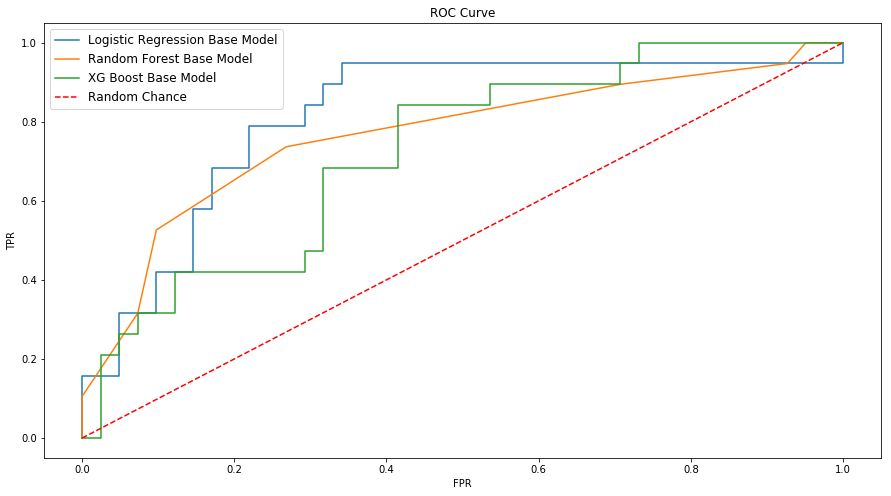

In [69]:
plt.subplots(figsize=(15,8))

plt.plot(fpr_basic, tpr_basic, '')
plt.plot(fpr_rf, tpr_rf, '')
plt.plot(fpr_xg, tpr_xg, '')

plt.plot([0,1],[0,1],'r--')
plt.legend(['Logistic Regression Base Model','Random Forest Base Model','XG Boost Base Model', 'Random Chance', 'Optimized Threshold'], fontsize = 12)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=100, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])
DEATH_EVENT    0.316667
pred           0.150000
error          0.266667
dtype: float64
[[38  3]
 [13  6]]
0.926829268292683 0.3157894736842105

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            mi...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
DEATH_EVENT    0.316667
pred           0.416667
error   

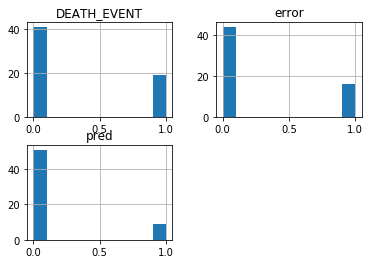

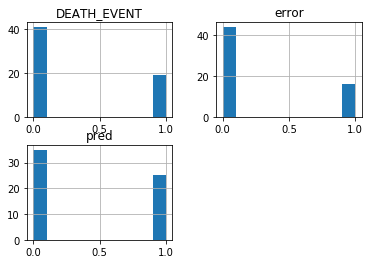

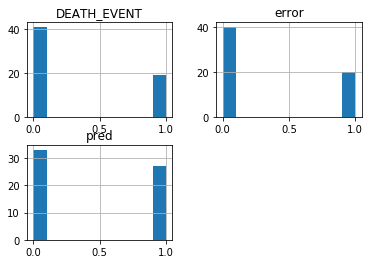

In [71]:
for i,v in enumerate([scale_lr_pipeline,scale_rf_pipeline,scale_xg_pipeline]):
    print(v)
    pred = v.predict(X_test)
    y_test = pd.DataFrame(y_test)
    y_test['pred'] = pred

    #zero-one error
    y_test['error'] = np.where(y_test.DEATH_EVENT == y_test.pred,0,1)
    print(y_test.mean())
    y_test.hist()
    print(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred']))

    TP_low = metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[0][0] / np.sum(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[0])
    TP_top = metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[1][1] / np.sum(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[1])
    print(TP_low,TP_top)
    print()

### Feature Interaction

In [72]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time', 'DEATH_EVENT', 'high_blood_pressure_smoking', 'diabetes_smoking', 'age_smoking', 'sex_smoking', 'anaemia_smoking'], dtype='object')

In [73]:
#add interaction between features:
df['high_blood_pressure_smoking'] = df.high_blood_pressure.astype(str) + df.smoking.astype(str)
df['diabetes_smoking'] = df.diabetes.astype(str) + df.smoking.astype(str)
df['age_smoking'] = df.age.astype(str) + df.smoking.astype(str)
df['sex_smoking'] = df.sex.astype(str) + df.smoking.astype(str)
df['anaemia_smoking'] = df.anaemia.astype(str) + df.smoking.astype(str)

In [74]:
#Define target and variables:
target_dummy = 'DEATH_EVENT'
dummy_variables = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
numerical_variables = ['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine', 'serum_sodium']
interaction = ['high_blood_pressure_smoking','diabetes_smoking','age_smoking','sex_smoking','anaemia_smoking']
all_variables = dummy_variables + numerical_variables + interaction

In [75]:
#convert dummy to categorical dtypes
for col in [dummy_variables+interaction]:
    df[col] = df[col].astype('category')
df.dtypes

age                             float64
anaemia                        category
creatinine_phosphokinase          int64
diabetes                       category
ejection_fraction                 int64
high_blood_pressure            category
platelets                       float64
serum_creatinine                float64
serum_sodium                      int64
sex                            category
smoking                        category
time                              int64
DEATH_EVENT                       int64
high_blood_pressure_smoking    category
diabetes_smoking               category
age_smoking                    category
sex_smoking                    category
anaemia_smoking                category
dtype: object

In [76]:
target = df[target_dummy]
features = df[all_variables]

#Create train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 2, stratify = target)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Check if fraction of positive class is similar in train and test
print(np.mean(y_test))
print(np.mean(y_train))

#We scale the data, to get better results. I will not test this, as normally we get better results using scaled data:
min_max_sc = MinMaxScaler()

#############Model 1: Logistic Regression##################
#Because we have unbalanced data, I already pick 'balanced' for class_weight in my base model. No need to test this. For sure
# it will give better results:
lr_basic = LogisticRegression(C = 1, random_state = 100, solver = 'warn', max_iter = 1000)
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', lr_basic)])

#################Model 2: Random Forest Classification###################
rfc_basic = RandomForestClassifier()
scale_rf_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', rfc_basic)])

#################Model 3: XG Boost############
xgboost_basic = xgb.XGBClassifier()
scale_xg_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', xgboost_basic)])

#Encode categorical features
encoder = ce.CatBoostEncoder() 
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.fit_transform(X_test, y_test)

#############################################################
#Run all three base models and get their initial performance:
scale_lr_pipeline.fit(X_train, y_train) #method for random forest classifier) #Logistic Regression
scale_rf_pipeline.fit(X_train, y_train) #Random Forest Classification
scale_xg_pipeline.fit(X_train, y_train) #XG Boost Classification

print(scale_lr_pipeline.score(X_train, y_train))
print(scale_rf_pipeline.score(X_train, y_train))
print(scale_xg_pipeline.score(X_train, y_train))

(239, 16)
(60, 16)
(239,)
(60,)
0.31666666666666665
0.32217573221757323
0.7447698744769874
0.9874476987447699
1.0


C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\

In [77]:
y_pred_proba_lr = scale_lr_pipeline.predict_proba(X_test) #returns the predicted probability 
y_pred_proba_rf = scale_rf_pipeline.predict_proba(X_test) #returns the predicted probability 
y_pred_proba_xg = scale_xg_pipeline.predict_proba(X_test) #returns the predicted probability 

#ROC AUC Score
print('Logistic regression:', roc_auc_score(y_test, pos_proba_lr))
print('Random Forest Classifier:', roc_auc_score(y_test, pos_proba_rf))
print('XG Boost:', roc_auc_score(y_test, pos_proba_xg))

Logistic regression: 0.8151476251604619
Random Forest Classifier: 0.766367137355584
XG Boost: 0.72400513478819


Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=100, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])
DEATH_EVENT    0.316667
pred           0.216667
error          0.266667
dtype: float64
[[36  5]
 [11  8]]
0.8780487804878049 0.42105263157894735

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('model', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            mi...obs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])
DEATH_EVENT    0.316667
pred           0.833333
error 

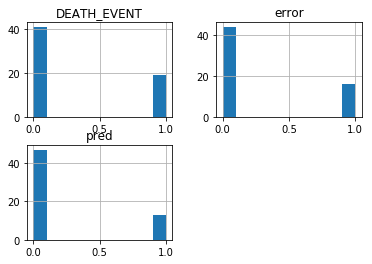

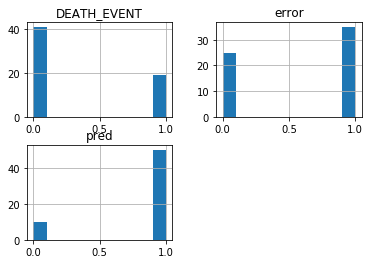

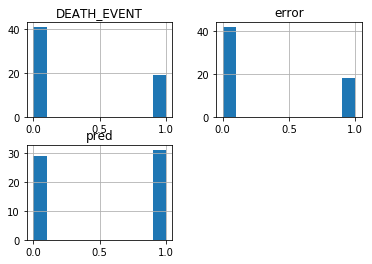

In [81]:
for i,v in enumerate([scale_lr_pipeline,scale_rf_pipeline,scale_xg_pipeline]):
    print(v)
    pred = v.predict(X_test)
    y_test = pd.DataFrame(y_test)
    y_test['pred'] = pred

    #zero-one error
    y_test['error'] = np.where(y_test.DEATH_EVENT == y_test.pred,0,1)
    print(y_test.mean())
    y_test.hist()
    print(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred']))

    TP_low = metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[0][0] / np.sum(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[0])
    TP_top = metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[1][1] / np.sum(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[1])
    print(TP_low,TP_top)
    print()

### Ensemble using Interaction Features

In [82]:
target = df[target_dummy]
features = df[all_variables]

#Create train and test data
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state = 2, stratify = target)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

#Check if fraction of positive class is similar in train and test
print(np.mean(y_test))
print(np.mean(y_train))

#We scale the data, to get better results. I will not test this, as normally we get better results using scaled data:
min_max_sc = MinMaxScaler()

#############Model 1: Logistic Regression##################
#Because we have unbalanced data, I already pick 'balanced' for class_weight in my base model. No need to test this. For sure
# it will give better results:
lr_basic = LogisticRegression(C = 1, random_state = 100, solver = 'warn', max_iter = 1000)
scale_lr_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', lr_basic)])

#################Model 2: Random Forest Classification###################
rfc_basic = RandomForestClassifier()
scale_rf_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', rfc_basic)])

#################Model 3: XG Boost############
xgboost_basic = xgb.XGBClassifier()
scale_xg_pipeline = Pipeline(steps = [('scaler', min_max_sc), ('model', xgboost_basic)])

#Encode categorical features
encoder = ce.CatBoostEncoder() 
X_train = encoder.fit_transform(X_train, y_train)
X_test = encoder.fit_transform(X_test, y_test)

#############################################################
#Run all three base models and get their initial performance:
scale_lr_pipeline.fit(X_train, y_train) #method for random forest classifier) #Logistic Regression
scale_rf_pipeline.fit(X_train, y_train) #Random Forest Classification
scale_xg_pipeline.fit(X_train, y_train) #XG Boost Classification

print(scale_lr_pipeline.score(X_train, y_train))
print(scale_rf_pipeline.score(X_train, y_train))
print(scale_xg_pipeline.score(X_train, y_train))

(239, 16)
(60, 16)
(239,)
(60,)
0.31666666666666665
0.32217573221757323
0.7447698744769874
0.9790794979079498
1.0


C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\jrathfelder\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\

In [93]:
#let us use all three models for ensembling:
#Get probabilities to display roc auc curve:
y_pred_proba_lr = scale_lr_pipeline.predict_proba(X_test) #returns the predicted probability 
y_pred_proba_rf = scale_rf_pipeline.predict_proba(X_test) #returns the predicted probability 
y_pred_proba_xg = scale_xg_pipeline.predict_proba(X_test) #returns the predicted probability 

neg_prob = []
pos_prob = []

for i,v in enumerate(range(0,len(y_pred_proba_lr))):
    neg_prob.append((y_pred_proba_lr[0:,0][i]  + y_pred_proba_xg[0:,0][i])/2)
    pos_prob.append((y_pred_proba_lr[0:,1][i]  + y_pred_proba_xg[0:,1][i])/2)
    
final_pred = []
for i,v in enumerate(range(0,len(neg_prob))):
    if neg_prob[i] > pos_prob[i]:
        final_pred.append(0)
    else:
        final_pred.append(1)    

In [94]:
#y_test = y_test['DEATH_EVENT']
#Get TPR and FPR and threshold values to plot curve:
fpr_basic, tpr_basic, threshold_ensemble = metrics.roc_curve(y_test, pos_prob, drop_intermediate = False)
#ROC AUC Score
print('Ensemble roc auc:', roc_auc_score(y_test, pos_prob))

Ensemble roc auc: 0.8061617458279846


DEATH_EVENT    0.316667
pred           0.450000
error          0.266667
dtype: float64
[[29 12]
 [ 4 15]]
0.7073170731707317 0.7894736842105263



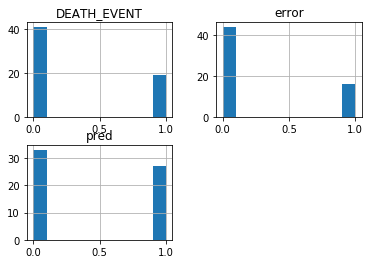

In [92]:
#calculate error using ensemble prediction
y_test = pd.DataFrame(y_test)
y_test['pred'] = final_pred

#zero-one error
y_test['error'] = np.where(y_test.DEATH_EVENT == y_test.pred,0,1)
print(y_test.mean())
y_test.hist()
print(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred']))

TP_low = metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[0][0] / np.sum(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[0])
TP_top = metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[1][1] / np.sum(metrics.confusion_matrix(y_test['DEATH_EVENT'], y_test['pred'])[1])
print(TP_low,TP_top)
print()